# Local Impact of Coal Mining on Public Health

In [164]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from urllib.request import urlopen
import json
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

## Motivation

Although relatively inexpensive, coal is reasonably considered to be one of the least environmentally friendly fossil fuels: according to $\href{https://www.iea.org/commentaries/it-s-critical-to-tackle-coal-emissions}{IEA}$, coal power plants produce a fifth of global greenhouse gas emissions, which is more than any other source of power. Coal mining process is not harmless either: coal mines emit more methane than oil and gas sector, and these emissions have been growing in recent years despite a slight decrease in coal production.

Air pollution caused by coal is a negative externality of the production business, as it affects the social welfare by provoking various diseases among local residents. The goal of the current study is to quantify the effect of coal production facilities on the health condition of local residents.

The relevance of the topic is fueled by an increasingly important role of Environmental, Social and Governance (ESG) standards in business, as well as the global decarbonization trend. Clear understanding of negative externalities of coal mining industry may assist policy making in health financing, enviromnent and industry regulation.

In this study, a panel data on specific regions of Russia are used to quantify the local impact of coal production on residents of the region.

## Identification Strategy

To identify the effect of coal mining on public health, one needs to compare the health condition of people living in industrial areas against those living in non-industrial areas. The mechanism behind this is linked to the environment: as coal mining is an environmentally harmful industry, the facilities affect air quality of the surrounding areas, which makes local people more prone to various diseases, such as respiratory, cardiovascular, and cancer.

However, it can be reasonably argued that industrial regions tend to enjoy greater tax revenues, thus being able to provide the residents with more accessible and better-quality medical services. This is supposed to offset – at least partly – the negative effect of mining production. This is why one needs to control for access to healthcare in order to identify the partial effect of mining industry.

The baseline model for identification is as follows:

\begin{equation}
    \textbf{Health}_{it} = \alpha + \beta \textbf{Coal}_i + \gamma \textbf{Healthcare}_{it} + \text{FE}_t + \varepsilon_{it}\
\end{equation}

Where $\textbf{Health}$ is the outcome variable which reflects the condition of public health, $\textbf{Coal}$ reflects the presence of coal mining industry in the region, $\textbf{Healthcare}$ measures the access of residents to healthcare services, FE accounts for year fixed effects.

The number of diagnosed diseases per 100 thousand people of local population is used as the outcome variable. Two options are tested: all diseases $(\textit{all_dis})$ and respiratory diseases only $(\textit{br_dis})$. For coal mining indicator, a dummy variable $\textit{coal}$ is used which equals 1 for regions with significant coal mining facilities in operation, and zero for regions which do not have any major extractive industry facilities at all. Healthcare services is proxied with $\ln(\textit{doctors})$ – the amount of medical personnel in the region, logarithmic-scaled to account for difference in region size.

For both measures of health – all diseases and resipratory diseases only – OLS estimation is used.

## Data

Data on $\href{https://www.fedstat.ru/indicator/41699}{diagnosed diseases}$ and $\href{https://www.fedstat.ru/indicator/31547}{medical personnel}$ are provided by the Ministry of Healthcare of the Russian Federation. The coal industry dummy is assigned 1 to the following regions, which $\href{http://www.mining-portal.ru/publish/regionyi-dobyichi-uglya--top-7/}{are}$ the most significant coal producers in Russia: Kemerovo Oblast (Kuzbass), Sakha Republic (Yakutia), Krasnoyarsk Krai, Komi Republic, Zabaikalsky Krai. The coal dummy is assigned 0 to the following regions, which are, according to $\href{https://gks.ru/free_doc/new_site/business/prom/natura/god10.htm}{Rosstat}$, the lowest in Russia by the volume of any extractive industry production: Republic of Mordovia, Tambov Oblast, Oryol Oblast, Kabardino-Balkar Republic, Bryansk Oblast, Chuvash Republic, Republic of Mary El, Republic of North Ossetia – Alanya, Tver Oblast, Vologda Oblast, Altai Republic, Ryazan Oblast, Novgorod Oblast, Ivanovo Oblast. The remaining regions of Russia are not included in the analysis.

In [165]:
df = pd.read_excel("nre_data_selreg.xlsx")

In [166]:
# assigning coal vs. non-coal dummies

coal_producing = ['Kuzbass', 'Yakutia', 'Kranoyarsk', 'Komi', 'Zabaikalsky']
df['coal'] = df.apply(lambda row : 1 if row['latin_key'] in coal_producing else 0, axis=1)

In [167]:
df.head(5)

,latin_key,cyrillic_key,prod2015,prod2016,prod2017,prod2018,prod2019,prod2020,prod2021,all_dis2014,...,br_dis2018,br_dis2020,doctors2014,doctors2015,doctors2016,doctors2017,doctors2018,doctors2019,doctors2020,coal
0,Mordovia,Республика Мордовия,127.5,71.4,83.7,119.3,118.0,103.8,106.2,151941.9,...,27504.7,37440.5,4364,4340,4330,4290,4258,4222,4251,0
1,Tambov,Тамбовская область,108.3,99.4,101.5,110.6,100.6,80.1,101.9,146460.4,...,32664.0,39100.1,3675,3763,3849,3892,3892,4061,4221,0
2,Oryol,Орловская область,77.9,73.7,141.0,120.6,114.3,98.1,95.3,184341.2,...,49513.6,58855.4,3293,3382,3369,3355,3309,3284,3277,0
3,KBR,Кабардино-Балкарская Республика,120.7,85.4,130.6,123.5,96.5,80.2,104.3,110771.2,...,19563.6,23767.0,3954,3768,3900,3916,3927,4075,4177,0
4,Bryansk,Брянская область,92.9,77.9,87.0,89.8,131.6,96.8,97.5,171126.0,...,33806.6,40274.0,4569,4653,4778,4931,4861,4792,4793,0


In [168]:
# reshaping the dataframe from wide to long
df = (pd.wide_to_long(df, ['prod', 'all_dis', 'br_dis', 'doctors'], i = 'latin_key', j = 'year')
      .reset_index()
     )

Before visualizing the quantitative indicators, a log-transfromation is applied to account for size differences.

In [171]:
for col in ['all_dis', 'br_dis', 'doctors']:
    df['ln_' + col] = np.log(df[col])

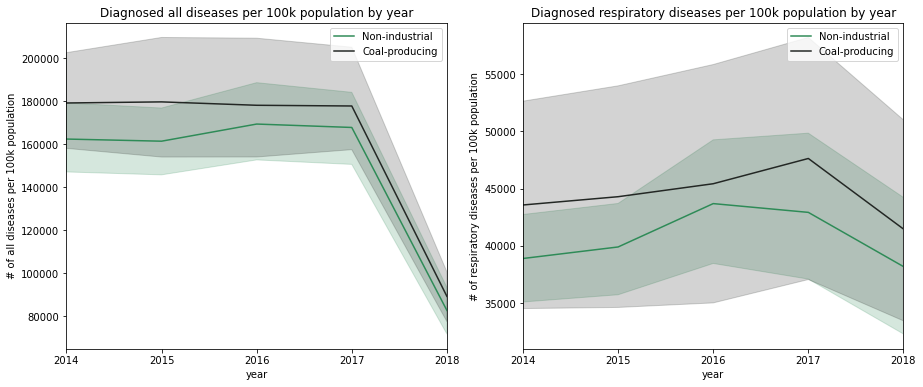

In [172]:
# visualize disease dynamics
f, axs = plt.subplots(1,2,figsize=(15,6))
for ax, label, title in zip(axs, ['all_dis', 'br_dis'], ['all', 'respiratory']):
    g = sns.lineplot(data=df,
                     x='year',
                     y=label,
                     hue='coal',
                     ax=ax,
                     legend=False,
                     palette=sns.dark_palette('seagreen', as_cmap=False, n_colors=2, reverse=True))
    g.set_xbound(2014, 2018)
    g.set_xticks(ticks = np.arange(2014,2019), minor=False)
    g.set_ylabel(f"# of {title} diseases per 100k population")
    g.legend(labels = ['Non-industrial', 'Coal-producing'])
    g.set_title(f"Diagnosed {title} diseases per 100k population by year")

It can be seen from the data that even with a major decline in 2018, people in coal-producing regions are more often diagnosed with respiratory diseases and all kinds of diseases combined than the residents of non-industrial regions.

Text(0.5, 1.0, 'Non-industrial regions')

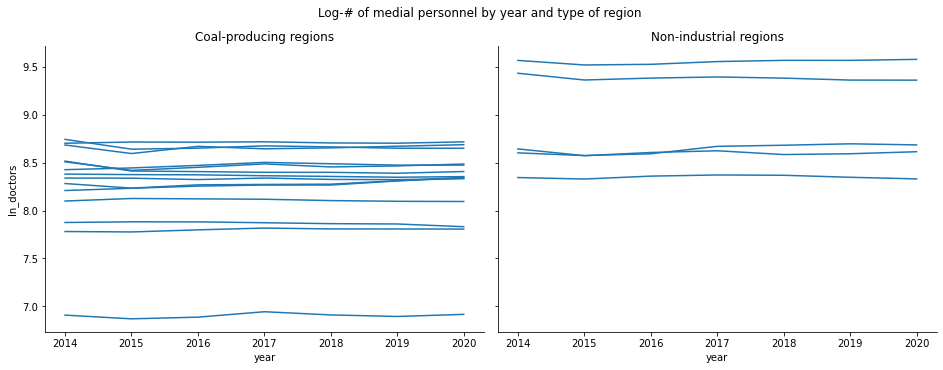

In [173]:
# visualizing the number of medical personnel
g = sns.relplot(data=df,
                x='year',
                y='ln_doctors',
                col='coal',
                kind='line',
                units='latin_key',
                estimator=None,
                markers=True,
                height=5,
                aspect=1.3
               )
g.fig.suptitle("Log-# of medial personnel by year and type of region")
plt.subplots_adjust(top=0.87)
g.axes[0,0].set_title("Coal-producing regions")
g.axes[0,1].set_title("Non-industrial regions")

It is worth expecting that the medical staff count is higher in coal regions, because those regions are greater in size.

## Estimation Results

Applying OLS estimation to four different specifications. Specifications 1 and 2 use all cases per 100k population as the outcome variable, while specifications 3 and 4 focus on respiratory disesases only, which is expected to be a more precise measure when it comes to the effect of coal mining. Moreover, specifications 1 and 3 use absolute values of cases per 100k population, while specifications 2 and 4 use logarithmically scales values of those. All four specifications include year fixed effects.

In [174]:
df_reg = df
reg0 = smf.ols('all_dis ~ coal + ln_doctors + C(year)', data=df_reg).fit()
reg1 = smf.ols('ln_all_dis ~ coal + ln_doctors + C(year)', data=df_reg).fit()
reg2 = smf.ols('br_dis ~ coal + ln_doctors + C(year)', data=df_reg).fit()
reg3 = smf.ols('ln_br_dis ~ coal + ln_doctors + C(year)', data=df_reg).fit()
print("                   (1)         (2)         (3)        (4)")
print(summary_col([reg0,reg1,reg2,reg3],stars=True,float_format='%0.2f'))

                   (1)         (2)         (3)        (4)

                  all_dis    ln_all_dis    br_dis   ln_br_dis
-------------------------------------------------------------
Intercept       261981.61*** 12.67***   98886.20*** 12.01*** 
                (49589.74)   (0.34)     (17353.44)  (0.42)   
C(year)[T.2015] -988.87      -0.01      692.29      0.02     
                (9480.70)    (0.07)     (3317.68)   (0.08)   
C(year)[T.2016] 4658.62      0.02       3899.98     0.09     
                (9479.14)    (0.07)     (3317.13)   (0.08)   
C(year)[T.2017] 3589.51      0.02       4028.11     0.08     
                (9478.66)    (0.07)     (3316.96)   (0.08)   
C(year)[T.2018] -82369.37*** -0.69***   -1141.39    -0.04    
                (9478.84)    (0.07)     (3317.03)   (0.08)   
C(year)[T.2019] -0.00        -0.00*     -0.00       -0.00    
                (0.00)       (0.00)     (0.00)      (0.00)   
C(year)[T.2020] -3825.83     -0.02      3963.73     0.09     
           

It can be seen from the results table that the effect of coal-mining region dummy on frequency of all types of diseases is positive and statistically significant at 5% level. According to the estimation results, people living in coal-mining regions are ceteris paribus diagnosed with medical diseases 13% more often (or roughly 18k more cases per 100k residents) than people from regions without any major extractive industry facilities.

As for the impact of coal mining region dummy on respiratory diseases, the frequency effect is positive and statistically significant at 5% level. Numerically, people from coal-mining regions tend to be diagnosed with respiratory diseases 20% more often (or 8.2k more cases per 100k residents) than people from regions where extractive industry is nonexistent.